# Logistic Regression

This is the third programming assignment for CSCE478/878 Introduction to Machine Learning on Logistic Regression. This notebook is divided into 2 main sections, and 3 subsections each
1. **Part A Logistic Regression - Binary Classification**
    1. Model Code
    1. Load, Partition and Scale Data
    1. Model Evaluation
1. **Part B Logistic Regression - Multiclass Classification**
    1. Model Code
    1. Load, Partition and Scale Data
    1. Model Evaluation

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import itertools
import math
from math import exp
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

## Part A-I Model Code Logistic Regression - Binary Classification

### 1. Implement the following function that computes the sigmoid score of samples.

In [58]:
def sigmoid(score):
    prob=1/(1+np.exp(-score))
    return prob

### 2. Implement the following function to compute the binary cross-entropy loss
 

In [3]:
def binary_cross_entropy(Y,Y_proba):
    loss=-(np.dot(Y,np.log(Y_proba))+np.dot((1-Y),np.log((1-Y_proba))))/Y.shape[0]
    return loss
    

###  3. Implement the following function to compute the l2 regularized binary cross-entropy loss.

In [4]:
def binary_cross_entropy_loss_l2(Y,Y_proba,theta,lambd):
    loss=-(np.dot(Y,np.log(Y_proba))+np.dot((1-Y),np.log((1-Y_proba))))/Y.shape[0] + 0.5*lambd*np.dot(theta[1:],theta[1:])/Y.shape[0] 
    return loss
    

### 4. Implement the following function to compute the l1 regularized binary cross-entropy loss.

In [5]:
def binary_cross_entropy_loss_l1(Y,Y_proba,theta,lambd):
    loss=-(np.dot(Y,np.log(Y_proba))+np.dot((1-Y),np.log((1-Y_proba))))/Y.shape[0] + lambd*np.sum(abs(theta[1:]))/Y.shape[0] 
    return loss

### 5 Implement a Logistic_Regression_Binary model class. It should have the following three methods. Note the that “fit” method should implement the batch gradient descent algorithm (based on the 1st order derivative of the loss).

In [6]:
class Logistic_Regression_Binary():
    def __init__(self, learning_rate=0.01, epochs=100, tol=None, regularizer=None, lambd=0.0, early_stopping=False,validation_fraction=0.1,plotLearningCurve=True, **kwargs):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.tol = tol
        self.regularizer = regularizer
        self.lambd = lambd
        self.w = None
        self.loss_train = []
        self.loss_validation = []
        self.early_stopping = early_stopping
        self.early_stopping_iterations = []
        self.tolerance_iterations = []
        self.validation_fraction = 0.1
        self.plotLearningCurve= plotLearningCurve
       
        return
    
    def fit(self, X, y):
        
        # Add x_0 = 1 for all for intercept and concat data
        x_0 = np.ones((X.shape[0],1))
        X = np.concatenate((x_0,X), axis=1)
        
        # Initialize all weights to 0
        self.w = np.zeros((X.shape[1],))
        
        if self.plotLearningCurve is True or self.early_stopping is True:
            prev_cost= 0
            prev_validation_cost=100000
            X_train,X_validation,y_train,y_validation =train_test_split(X,y,test_size=self.validation_fraction,shuffle=True)
            
            # Number of training samples
            m = len(X_train)
            
           # Run batch gradient descent up to self.epoch times
            for i in range(self.epochs):
                if self.regularizer == "l2":
                    new_cost= binary_cross_entropy_loss_l2(y_train,sigmoid(X_train.dot(self.w)),self.w,self.lambd)
                    self.loss_train.append(new_cost)
                    
                    new_validation_cost = binary_cross_entropy_loss_l2(y_validation,sigmoid(X_validation.dot(self.w)),self.w,self.lambd)
                    self.loss_validation.append(new_validation_cost)
                
                elif self.regularizer == 'l1':
                    new_cost= binary_cross_entropy_loss_l1(y_train,sigmoid(X_train.dot(self.w)),self.w,self.lambd)
                    self.loss_train.append(new_cost)
                    
                    new_validation_cost = binary_cross_entropy_loss_l1(y_validation,sigmoid(X_validation.dot(self.w)),self.w,self.lambd)
                    self.loss_validation.append(new_validation_cost)
                else:
                    # Calculate loss with current weights
                    new_cost = binary_cross_entropy(y_train,sigmoid(X_train.dot(self.w)))
                    self.loss_train.append(new_cost)
                    
                    # Calculate loss of validation data
                    new_validation_cost = binary_cross_entropy(y_validation,sigmoid(X_validation.dot(self.w)))
                    self.loss_validation.append(new_validation_cost)
            
              # Break if absolute cost of previous cost and current cost is smaller than self.tol
                if self.tol is not None:
                    if abs(prev_cost - new_cost) > self.tol:
                        prev_cost = new_cost
                    else:
                        self.tolerance_iterations = i # number of iterations for satisfying the tolerance
                        print('Early stopping because the tolerance is met')
                        break
                    
               # Break if validation loss is increasing (overfitting)
                if self.early_stopping is True:
                    if new_validation_cost < prev_validation_cost:
                        prev_validation_cost = new_validation_cost
                    else:
                        self.early_stopping_iterations = i # number of iterations for early stopping
                        print('Early stopping because the validation loss is not decreasing')
                        break
                    
               # Calculate gradient   
                grad = (X_train.T.dot(sigmoid(X_train.dot(self.w))-y_train))
            
               # Apply Regularization term to gradient
                if self.regularizer == "l2":
                    regularized_term = self.lambd*self.w
                    regularized_term[0] = 0 # Exclude the bias term
                    grad = grad + regularized_term
                
                elif self.regularizer == 'l1':
                    regularized_term = self.lambd * np.sign(self.w)
                    regularized_term[0] = 0 # Exclude the bias term
                    grad = grad + regularized_term
            
                # Update weights
                    self.w = self.w - (self.learning_rate/m)*grad
      
        else:
            # Number of training samples
            m = len(X)
            
            prev_cost= 0
            
           # Run batch gradient descent up to self.epoch times
            for i in range(self.epochs):
                if self.regularizer == "l2":
                    new_cost= binary_cross_entropy_loss_l2(y,sigmoid(X.dot(self.w)),self.w,self.lambd)
                
                elif self.regularizer == 'l1':
                    new_cost= binary_cross_entropy_loss_l1(y,sigmoid(X.dot(self.w)),self.w,self.lambd)
              
                else:
                    # Calculate loss with current weights
                    new_cost = binary_cross_entropy(y,sigmoid(X.dot(self.w)))
            
              # Break if absolute cost of previous cost and current cost is smaller than self.tol
                if self.tol is not None:
                    if abs(prev_cost - new_cost) > self.tol:
                        prev_cost = new_cost
                    else:
                        self.tolerance_iterations = i # number of iterations for satisfying the tolerance
                        print('Early stopping because the tolerance is met')
                        break
                    
               # Calculate gradient   
                grad = (X.T.dot(sigmoid(X.dot(self.w))-y))
            
               # Apply Regularization term to gradient
                if self.regularizer == "l2":
                    regularized_term = self.lambd*self.w
                    regularized_term[0] = 0 # Exclude the bias term
                    grad = grad + regularized_term
                
                elif self.regularizer == 'l1':
                    regularized_term = self.lambd * np.sign(self.w)
                    regularized_term[0] = 0 # Exclude the bias term
                    grad = grad + regularized_term
            
                # Update weights
                    self.w = self.w - (self.learning_rate/m)*grad
        
        if self.plotLearningCurve is True:                  
            # Plotting Learning Curve            
            epochs_xaxis=np.linspace(1.0,len(self.loss_train),num=len(self.loss_train))
            plt.figure(figsize=(12, 9), dpi=80)
            plt.plot(epochs_xaxis,self.loss_train, label = "Training")
            plt.plot(epochs_xaxis,self.loss_validation, label = "Validation")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.title("Learning Curve")
            plt.legend()
            plt.show()        
                
    def predict(self, X):
        
        x_0 = np.ones((X.shape[0],1))
        X = np.concatenate((x_0,X), axis=1)
        
        pred = sigmoid(X.dot(self.w))
        
        # Assign 1 for p(x) > 0.5, else 0
        pred = np.array(list(map(lambda x: 1 if x>0.5 else 0, pred)))
        
        return pred


## Part A-II: Load, Partition, and Scale Data

### 6. Read the Iris data using the sklearn.datasets.load_iris function. Create a data matrix X (numpy ndarray) and 1D column vector Y (numpy 1D array) containing the binary labels. Create Y by putting the value 1 if the target value Iris-Virginica, else put 0.

In [12]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [11]:
y = np.array(list(map(lambda x: 1 if x==2 else 0, y)))

### 7. Shuffle the rows of X. You may use a sklearn function.

In [13]:
X,y = shuffle(X,y)

### 8. Partition the data into train and test set. Use the partition function from your previous assignment or from sklearn.

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

### 9. Standardize the train and test set. Use the standardization function from your previous assignment or from sklearn.

In [11]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
scaler.fit(X_test)
X_test = scaler.transform(X_test)

## Part A-III: Model Evaluation

### 10. Model selection via Hyperparameter tuning: Use the kFold function from previous assignment or from sklearn to evaluate the performance of your model over each combination of parameters from the following sets. You may vary the range of values, if needed, and also for more experimentation.

In [12]:
def sFold(estimator,X,y,scoring,cv):
    size = len(X)
    size_fold = int(size/cv)
    range_index = [j for j in range(0,len(X))]
    score=[]
    #Partitioning of the data
    for i in range(cv):
        init=0+i*size_fold
        fin=(i+1)*size_fold
        partition_range_index = [j for j in range(init,fin)]
        
        #Feature and label data of the Fold
        X_partition = X[partition_range_index]
        y_partition = y[partition_range_index]
        
        #Feature and label data of  1-Fold        
        remainder_index = list(set(range_index).difference(set(partition_range_index)))
        X_remainder=X[remainder_index]
        y_remainder=y[remainder_index]
        
        #Fit the model to the 1-Fold data
        estimator.fit(X_remainder, y_remainder) 
        
        #Test the model on the fold data
        pred=estimator.predict(X_partition)
      
        if scoring=='accuracy':
            acc=accuracy_score(y_partition,pred)
            score.append(acc) 
            
    avg_score = np.mean(score)    
    return avg_score,score

In [13]:
lambd =[1.0,0,0.1,0.01,0.001,0.0001] 
epoch=[1000,10000]
learning_rate =[0.1, 0.01, 0.001, 0.001]
regularizer = ['l1', 'l2',None]
cv=5

results = {}

for lam in lambd:
    for epo in epoch:
        for eta in learning_rate:
            for reg in regularizer:
                label ='Lambda'+'_'+str(lam) + '_'+'Learning Rate'+'_'+ str(eta) +'_'+'Regularizer'+'_'+str(reg)+'_'+'Epochs'+'_'+ str(epo)
                model=Logistic_Regression_Binary(learning_rate = eta, epochs = epo, regularizer = reg, lambd = lam, early_stopping=True, plotLearningCurve=False)
                results[label] = sFold(model,X_train,y_train,scoring='accuracy',cv=cv)
                
print(results)

Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because t

Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because t

Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because t

Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because the validation loss is not decreasing
Early stopping because t

In [14]:
max_acc =0
min_config = ''
for key,pair in results.items():
    print(key + ": Accuracy " + str(pair[0]))
    if pair[0] >max_acc:
        max_acc=pair[0]
        max_config=key
print(max_acc)
print(max_config)

Lambda_1.0_Learning Rate_0.1_Regularizer_l1_Epochs_1000: Accuracy 0.8333333333333333
Lambda_1.0_Learning Rate_0.1_Regularizer_l2_Epochs_1000: Accuracy 0.6833333333333333
Lambda_1.0_Learning Rate_0.1_Regularizer_None_Epochs_1000: Accuracy 0.6833333333333333
Lambda_1.0_Learning Rate_0.01_Regularizer_l1_Epochs_1000: Accuracy 0.8833333333333334
Lambda_1.0_Learning Rate_0.01_Regularizer_l2_Epochs_1000: Accuracy 0.6833333333333333
Lambda_1.0_Learning Rate_0.01_Regularizer_None_Epochs_1000: Accuracy 0.6833333333333333
Lambda_1.0_Learning Rate_0.001_Regularizer_l1_Epochs_1000: Accuracy 0.8416666666666666
Lambda_1.0_Learning Rate_0.001_Regularizer_l2_Epochs_1000: Accuracy 0.6833333333333333
Lambda_1.0_Learning Rate_0.001_Regularizer_None_Epochs_1000: Accuracy 0.6833333333333333
Lambda_1.0_Learning Rate_0.1_Regularizer_l1_Epochs_10000: Accuracy 0.8833333333333334
Lambda_1.0_Learning Rate_0.1_Regularizer_l2_Epochs_10000: Accuracy 0.6833333333333333
Lambda_1.0_Learning Rate_0.1_Regularizer_None_Ep

### 11. Evaluate your best model on the test data and report the accuracy and confusion matrix. You may use the sklearn.metrics.confusion_matrix function for generating the confusion matrix.

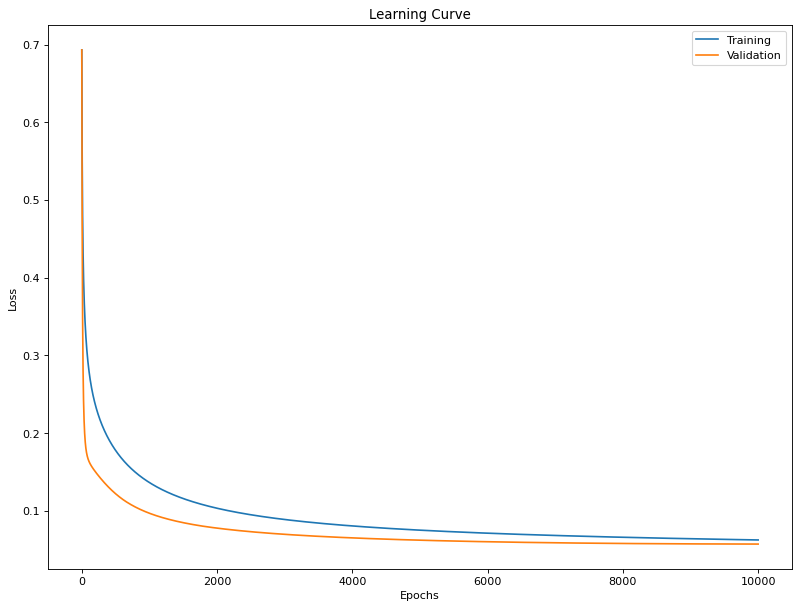


Train Accuracy:  0.975

Train Confusion Matrix:
[[80  2]
 [ 1 37]]

Test Accuracy:  0.9

Test Confusion Matrix:
[[18  0]
 [ 3  9]]

Test Precision = 1.000000
Test Recall = 0.750000
Test F1 Score = 0.857143

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        18
           1       1.00      0.75      0.86        12

    accuracy                           0.90        30
   macro avg       0.93      0.88      0.89        30
weighted avg       0.91      0.90      0.90        30



In [17]:
#Best Model
#Regularizer: L1
#Learning Rate: 0.1
#Lambda: 0.01
#Epochs: 10000

model = Logistic_Regression_Binary(learning_rate = 0.1, epochs = 10000, regularizer = 'l1', lambd = 0.01,early_stopping=True,plotLearningCurve=True)
model.fit(X_train, y_train)


y_train_predicted=model.predict(X_train)

y_test_predicted=model.predict(X_test)

#Confusion Matrix

accuracy_score_train = np.mean(y_train_predicted == y_train)
print("\nTrain Accuracy: ", accuracy_score_train)

print("\nTrain Confusion Matrix:")
print(confusion_matrix(y_train, y_train_predicted))


accuracy_score_test = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", accuracy_score_test)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


precision_test = precision_score(y_test, y_test_predicted) 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_predicted)
print("Test Recall = %f" % recall_test)


f1_test = f1_score(y_test, y_test_predicted)
print("Test F1 Score = %f" % f1_test)


print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

### 12. Using the best model, report the following in the Jupyter notebook: total number of iterations before the model converged, the final weightvector, and the learning curve


Weights of the Best Model:
[-8.52048599 -0.1156035  -1.21035575  5.24442786  6.47784955]

Number of Iterations for Convergence (no early-stopping):
10000


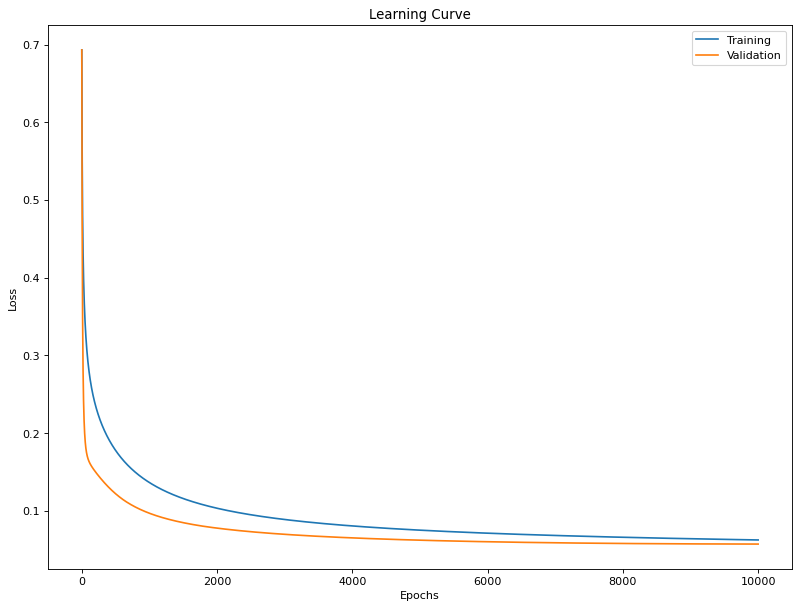

In [18]:
print("\nWeights of the Best Model:")
print(model.w)

#Maximum number of iterations is 100000 as shown in the learning curve. 
#The code returns the number of iterations when early stopping is applied, otherwise the max number of iterations is epochs
loss_train=model.loss_train
loss_validation=model.loss_validation
if model.early_stopping_iterations==[]:
    print("\nNumber of Iterations for Convergence ""(no early-stopping)"":")
    print(len(loss_train))
else:
        print("\nNumber of Iterations for Convergence ""(early-stopping)"":")
        print(model.early_stopping_iterations)

epochs_xaxis=np.linspace(1.0,len(loss_train),num=len(loss_train))
plt.figure(figsize=(12, 9), dpi=80)
plt.plot(epochs_xaxis,loss_train, label = "Training")
plt.plot(epochs_xaxis,loss_validation, label = "Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.show()

## Part B-I: Model Code Logistic Regression-Multiclass Classification

### 13. Implement the following function to convert the vector of class labels into a matrix containing a one-hot vector for each sample.

In [18]:
def one_hot_labels(Y):
    
    # Get unique labels in Y and number of observations
    unique_labels = np.unique(Y)
    n = len(Y)
    
    # Create one hot matrix
    labels = np.array(list(unique_labels)).reshape(len(unique_labels),1)
    one_hot_matrix = np.apply_along_axis(lambda x: np.full((n,),x),1,labels)
    one_hot_matrix = np.apply_along_axis(lambda x: (x==Y).astype(int),1,one_hot_matrix).T
    
    return one_hot_matrix

### 14. Implement the following function that computes the softmax score or the normalized exponential of the score of the samples.

In [20]:
def softmax(score):
    score = np.apply_along_axis(np.exp,0,score)
    score = np.apply_along_axis(lambda x: x/(sum(x)),1,score)
    
    return score

### 15. Implement the following function to compute the cross-entropy loss.

In [21]:
def cross_entropy_loss(Y_one_hot, Y_proba):
    loss = -np.sum(np.multiply(Y_one_hot,np.log(Y_proba)))/Y_one_hot.shape[0]
    
    return loss

### 16. Implement the following function to compute the l2 regularized cross-entropy loss.

In [22]:
def cross_entropy_loss_l2(Y_one_hot, Y_proba, Theta, lambd):
    loss = cross_entropy_loss(Y_one_hot, Y_proba) + 0.5*lambd*np.sum(np.square(Theta[1:]))/Y_one_hot.shape[0]
    return loss

### 17. Implement the following function to compute the l1 regularized cross-entropy loss.

In [23]:
def cross_entropy_loss_l1(Y_one_hot, Y_proba, Theta, lambd):
    loss = cross_entropy_loss(Y_one_hot, Y_proba) + lambd*np.sum(abs(Theta[1:]))/Y_one_hot.shape[0]
    return loss

### 18. Implement a Logistic_Regression_Multiclass model class that uses the softmax regression technique for performing multi-class classification. The model should have the following three methods. Note the that “fit” method should implement the batch gradient descent algorithm (based on the 1st order derivative of the loss).

In [57]:
class Logistic_Regression_Multiclass():
    def __init__(self, multi_class='softmax', learning_rate=0.01, epochs=100, tol=None, regularizer=None, lambd=0.0, early_stopping=False, validation_fraction=0.1, plotLearningCurve=True, **kwargs):
        self.multi_class = multi_class
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.tol = tol
        self.regularizer = regularizer
        self.lambd = lambd
        self.early_stopping = early_stopping
        self.validation_fraction = validation_fraction
        self.plotLearningCurve = plotLearningCurve
        self.W = None
        self.loss = []
        self.early_stopping_iterations=[]
        self.loss_validation = []
        
    def fit(self,X,Y):
        # Add 1 for bias term
        x_0 = np.ones((X.shape[0],1))
        X = np.concatenate((x_0,X), axis=1)
        Y= one_hot_labels(Y)
        
        if self.early_stopping or self.plotLearningCurve:
            valid_samples = math.floor(X.shape[0]*self.validation_fraction)
            validation_X = X[:valid_samples]
            X = X[valid_samples:]
            validation_Y = Y[:valid_samples]
            Y = Y[valid_samples:]
        
        # Set number of training data
        n = X.shape[0]
        
        # Initiate Weight Matrix
        W = np.zeros((X.shape[1],Y.shape[1]))
        
        loss = []
        loss_validation = []
        
        for i in range(self.epochs):
            # Prediction
            Mu = softmax(X.dot(W))
            
            if self.early_stopping or self.plotLearningCurve:
                Mu_validate = softmax(validation_X.dot(W))
            
            if self.regularizer == 'l2':
                reg = W
                reg[0,:] = 0
                G = self.lambd*reg
                l = cross_entropy_loss_l2(Y,Mu,W,self.lambd)
                if self.early_stopping:
                    l_val = cross_entropy_loss_l2(validation_Y,Mu_validate,W,self.lambd)
            elif self.regularizer == 'l1':
                reg = W
                reg[0,:] = 0
                G = self.lambd*np.sign(reg)
                l = cross_entropy_loss_l1(Y,Mu,W,self.lambd)
                if self.early_stopping or self.plotLearningCurve:
                    l_val = cross_entropy_loss_l2(validation_Y,Mu_validate,W,self.lambd)
            elif self.regularizer is None:
                G = 0
                l = cross_entropy_loss(Y,Mu)
                if self.early_stopping or self.plotLearningCurve:
                    l_val = cross_entropy_loss(validation_Y,Mu_validate)
                
            loss.append(l)
            if self.early_stopping or self.plotLearningCurve:
                loss_validation.append(l_val)
                
            # Gradient Descent loss decrease tolerance
            if self.tol is not None:
                if len(loss) > 1:
                    if abs(loss[-1]-loss[-2]) < self.tol:
                        break
            
            # Early stopping correction
            if self.early_stopping:
                if len(loss_validation) > 1:
                    if loss_validation[-2] - loss_validation[-1] < 0:
                        self.early_stopping_iterations = i # number of iterations for early stopping
                        print('Early stopping because the validation loss is not decreasing')
                        break
                    
            
            # Calculate first degree gradient derivative
            G = G + X.T.dot(softmax(X.dot(W))-Y)
            
            # Update weights
            W = W - (self.learning_rate/n)*G            
            
        self.W = W
        self.loss = loss
        if self.early_stopping or self.plotLearningCurve:
            self.loss_validation = loss_validation
        
        if self.plotLearningCurve is True:                  
            # Plotting Learning Curve            
            epochs_xaxis=np.linspace(1.0,len(self.loss),num=len(self.loss))
            plt.figure(figsize=(12, 9), dpi=80)
            plt.plot(epochs_xaxis,self.loss, label = "Training")
            plt.plot(epochs_xaxis,self.loss_validation, label = "Validation")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.title("Learning Curve")
            plt.legend()
            plt.show()  
        
    def predict(self,X):
        # Append bias term
        x_0 = np.ones((X.shape[0],1))
        X = np.concatenate((x_0,X), axis=1)
        
        predict_probablity = softmax(X.dot(self.W))
        
        return np.argmax(predict_probablity, axis=1)
            


## Part B-II: Load, Partition, and Scale Data

### 19. Read the Iris data using the sklearn.datasets.load_iris function. Create a data matrix X and 1D column vector Y containing the multi-lass labels. 

In [46]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

### 20. Shuffle the rows of X. You may use a sklearn function.

In [47]:
X,y = shuffle(X,y)

### 21. Partition the data into train and test set. Use the partition function from your previous assignment or from sklearn.

In [48]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

### 22. Standardize the train and test set. Use the standardization function from your previous assignment or from sklearn.

In [49]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
scaler.fit(X_test)
X_test = scaler.transform(X_test)

## Part B-III: Model Evaluation

### 23. Model selection via Hyperparameter tuning: Use the kFold function from previous assignment or from sklearn to evaluate the performance of your model over each combination of parameters from the following sets. You may vary the range of values, if needed, and also for more experimentation.

In [ ]:
lambd =[1.0,0,0.1,0.01,0.001,0.0001] 
epoch=[1000,10000]
learning_rate =[0.1, 0.01, 0.001, 0.0001]
regularizer = ['l1', 'l2',None]
cv=5

results = {}

for lam in lambd:
    for epo in epoch:
        for eta in learning_rate:
            for reg in regularizer:
                label ='Lambda'+'_'+str(lam) + '_'+'Learning Rate'+'_'+ str(eta) +'_'+'Regularizer'+'_'+str(reg)+'_'+'Epochs'+'_'+ str(epo)
                model=Logistic_Regression_Multiclass(learning_rate = eta, epochs = epo, regularizer = reg, lambd = lam, early_stopping=True, plotLearningCurve=False)
                results[label] = sFold(model,X_train,y_train,scoring='accuracy',cv=cv)
                
print(results)

In [52]:
max_acc =0
min_config = ''
for key,pair in results.items():
    print(key + ": Accuracy " + str(pair[0]))
    if pair[0] >max_acc:
        max_acc=pair[0]
        max_config=key
print(max_acc)
print(max_config)

Lambda_1.0_Learning Rate_0.1_Regularizer_l1_Epochs_1000: Accuracy 0.8083333333333333
Lambda_1.0_Learning Rate_0.1_Regularizer_l2_Epochs_1000: Accuracy 0.8
Lambda_1.0_Learning Rate_0.1_Regularizer_None_Epochs_1000: Accuracy 0.9666666666666666
Lambda_1.0_Learning Rate_0.01_Regularizer_l1_Epochs_1000: Accuracy 0.8083333333333333
Lambda_1.0_Learning Rate_0.01_Regularizer_l2_Epochs_1000: Accuracy 0.8
Lambda_1.0_Learning Rate_0.01_Regularizer_None_Epochs_1000: Accuracy 0.9083333333333332
Lambda_1.0_Learning Rate_0.001_Regularizer_l1_Epochs_1000: Accuracy 0.7916666666666666
Lambda_1.0_Learning Rate_0.001_Regularizer_l2_Epochs_1000: Accuracy 0.7916666666666666
Lambda_1.0_Learning Rate_0.001_Regularizer_None_Epochs_1000: Accuracy 0.8083333333333333
Lambda_1.0_Learning Rate_0.0001_Regularizer_l1_Epochs_1000: Accuracy 0.7833333333333333
Lambda_1.0_Learning Rate_0.0001_Regularizer_l2_Epochs_1000: Accuracy 0.7833333333333333
Lambda_1.0_Learning Rate_0.0001_Regularizer_None_Epochs_1000: Accuracy 0.7

### 24. Evaluate your best model on the test data and report the accuracy and confusion matrix. You may use the sklearn.metrics.confusion_matrix function for generating the confusion matrix.

Early stopping because the validation loss is not decreasing


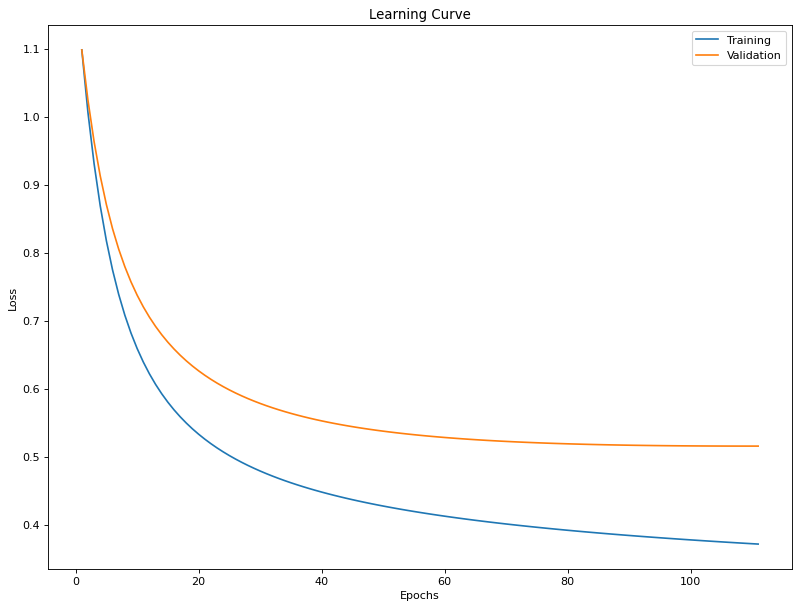


Train Accuracy:  0.8333333333333334

Train Confusion Matrix:
[[[81  0]
  [ 0 39]]

 [[75  3]
  [17 25]]

 [[64 17]
  [ 3 36]]]

Test Accuracy:  0.8666666666666667

Test Confusion Matrix:
[[[19  0]
  [ 0 11]]

 [[22  0]
  [ 4  4]]

 [[15  4]
  [ 0 11]]]


In [61]:
#Best Model
#Regularizer: L1
#Learning Rate: 0.1
#Lambda: 0
#Epochs: 1000

model = Logistic_Regression_Multiclass(learning_rate = 0.1, epochs = 1000, regularizer = 'l1', lambd = 0,early_stopping=True,plotLearningCurve=True)
model.fit(X_train, y_train)


y_train_predicted=model.predict(X_train)

y_test_predicted=model.predict(X_test)

#Confusion Matrix

accuracy_score_train = np.mean(y_train_predicted ==y_train)
print("\nTrain Accuracy: ", accuracy_score_train)

print("\nTrain Confusion Matrix:")
print(multilabel_confusion_matrix(y_train, y_train_predicted))


accuracy_score_test = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", accuracy_score_test)


print("\nTest Confusion Matrix:")
print(multilabel_confusion_matrix(y_test, y_test_predicted))

### 25. Using the best model, report the following in the Jupyter notebook: total number of iterations before the model converged, the final weightvector, and the learning curve


Weights of the Best Model:
[[ 0.          0.          0.        ]
 [-0.51769994  0.22899988  0.28870006]
 [ 0.70140577 -0.79524422  0.09383845]
 [-0.85326036  0.24748166  0.6057787 ]
 [-0.79737811 -0.13985974  0.93723785]]

Number of Iterations for Convergence (early-stopping):
110


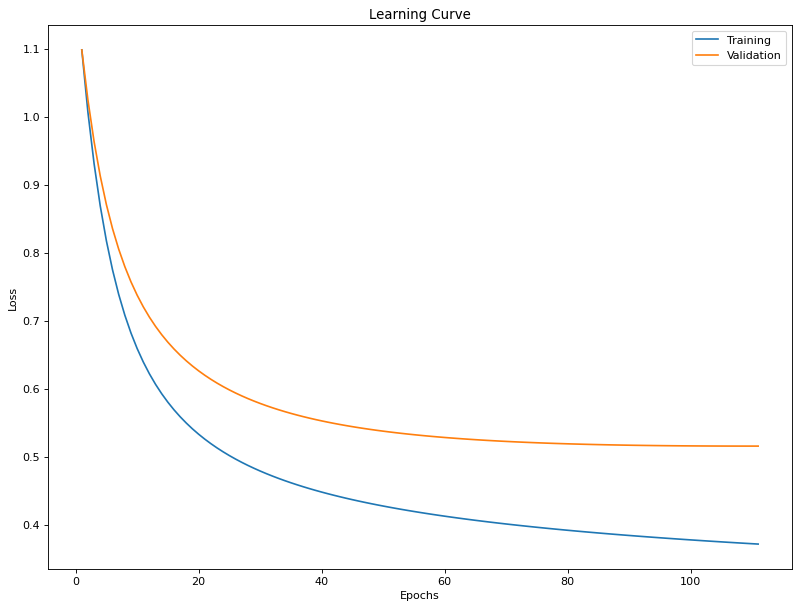

In [62]:
print("\nWeights of the Best Model:")
print(model.W)

#Maximum number of iterations is 100000 as shown in the learning curve. 
#The code returns the number of iterations when early stopping is applied, otherwise the max number of iterations is epochs
loss_train=model.loss
loss_validation=model.loss_validation
if model.early_stopping_iterations==[]:
    print("\nNumber of Iterations for Convergence ""(no early-stopping)"":")
    print(len(loss_train))
else:
    print("\nNumber of Iterations for Convergence ""(early-stopping)"":")
    print(model.early_stopping_iterations)

epochs_xaxis=np.linspace(1.0,len(loss_train),num=len(loss_train))
plt.figure(figsize=(12, 9), dpi=80)
plt.plot(epochs_xaxis,loss_train, label = "Training")
plt.plot(epochs_xaxis,loss_validation, label = "Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.show()

## Extra Credit

### 26. Implement the one-vs-all (OvA) technique for performing multi-class classification in the Logistic_Regression_Multiclass model.

In [112]:
class Logistic_Regression_Multiclass():
    def __init__(self, multi_class='softmax', learning_rate=0.01, epochs=100, tol=None, regularizer=None, lambd=0.0, early_stopping=False, validation_fraction=0.1, plotLearningCurve=True, **kwargs):
        self.multi_class = multi_class
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.tol = tol
        self.regularizer = regularizer
        self.lambd = lambd
        self.early_stopping = early_stopping
        self.validation_fraction = validation_fraction
        self.plotLearningCurve = plotLearningCurve
        self.W = []
        self.loss = []
        self.early_stopping_iterations=[]
        self.loss_validation = []
        
    def fit(self,X,Y):
        if self.multi_class == 'softmax':
            # Add 1 for bias term
            x_0 = np.ones((X.shape[0],1))
            X = np.concatenate((x_0,X), axis=1)
            Y = one_hot_labels(Y)

            if self.early_stopping or self.plotLearningCurve:
                valid_samples = math.floor(X.shape[0]*self.validation_fraction)
                validation_X = X[:valid_samples]
                X = X[valid_samples:]
                validation_Y = Y[:valid_samples]
                Y = Y[valid_samples:]

            # Set number of training data
            n = X.shape[0]

            # Initiate Weight Matrix
            W = np.zeros((X.shape[1],Y.shape[1]))

            loss = []
            loss_validation = []

            for i in range(self.epochs):
                # Prediction
                Mu = softmax(X.dot(W))

                if self.early_stopping or self.plotLearningCurve:
                    Mu_validate = softmax(validation_X.dot(W))

                if self.regularizer == 'l2':
                    reg = W
                    reg[0,:] = 0
                    G = self.lambd*reg
                    l = cross_entropy_loss_l2(Y,Mu,W,self.lambd)
                    if self.early_stopping:
                        l_val = cross_entropy_loss_l2(validation_Y,Mu_validate,W,self.lambd)
                elif self.regularizer == 'l1':
                    reg = W
                    reg[0,:] = 0
                    G = self.lambd*np.sign(reg)
                    l = cross_entropy_loss_l1(Y,Mu,W,self.lambd)
                    if self.early_stopping or self.plotLearningCurve:
                        l_val = cross_entropy_loss_l2(validation_Y,Mu_validate,W,self.lambd)
                elif self.regularizer is None:
                    G = 0
                    l = cross_entropy_loss(Y,Mu)
                    if self.early_stopping or self.plotLearningCurve:
                        l_val = cross_entropy_loss(validation_Y,Mu_validate)

                loss.append(l)
                if self.early_stopping or self.plotLearningCurve:
                    loss_validation.append(l_val)

                # Gradient Descent loss decrease tolerance
                if self.tol is not None:
                    if len(loss) > 1:
                        if abs(loss[-1]-loss[-2]) < self.tol:
                            break

                # Early stopping correction
                if self.early_stopping:
                    if len(loss_validation) > 1:
                        if loss_validation[-2] - loss_validation[-1] < 0:
                            self.early_stopping_iterations = i # number of iterations for early stopping
                            print('Early stopping because the validation loss is not decreasing')
                            break


                # Calculate first degree gradient derivative
                G = G + X.T.dot(softmax(X.dot(W))-Y)

                # Update weights
                W = W - (self.learning_rate/n)*G            

            self.W = W
            self.loss = loss
            if self.early_stopping or self.plotLearningCurve:
                self.loss_validation = loss_validation

            if self.plotLearningCurve is True:                  
                # Plotting Learning Curve            
                epochs_xaxis=np.linspace(1.0,len(self.loss),num=len(self.loss))
                plt.figure(figsize=(12, 9), dpi=80)
                plt.plot(epochs_xaxis,self.loss, label = "Training")
                plt.plot(epochs_xaxis,self.loss_validation, label = "Validation")
                plt.xlabel("Epochs")
                plt.ylabel("Loss")
                plt.title("Learning Curve")
                plt.legend()
                plt.show()  
                
        elif self.multi_class == 'OvA':
            classes = one_hot_labels(Y)
            
            # Add x_0 = 1 for all for intercept and concat data
            x_0 = np.ones((X.shape[0],1))
            X = np.concatenate((x_0,X), axis=1)
            
            for i in range(0,classes.shape[1]):

                # Initialize all weights to 0
                w = np.zeros((X.shape[1],))

                if self.plotLearningCurve is True or self.early_stopping is True:
                    prev_cost= 0
                    prev_validation_cost=100000
                    X_train,X_validation,y_train,y_validation =train_test_split(X,classes[:,i],test_size=self.validation_fraction,shuffle=True)

                    # Number of training samples
                    m = len(X_train)

                   # Run batch gradient descent up to self.epoch times
                    for i in range(self.epochs):
                        if self.regularizer == "l2":
                            new_cost= binary_cross_entropy_loss_l2(y_train,sigmoid(X_train.dot(w)),w,self.lambd)
                            self.loss.append(new_cost)

                            new_validation_cost = binary_cross_entropy_loss_l2(y_validation,sigmoid(X_validation.dot(w)),w,self.lambd)
                            self.loss_validation.append(new_validation_cost)

                        elif self.regularizer == 'l1':
                            new_cost= binary_cross_entropy_loss_l1(y_train,sigmoid(X_train.dot(w)),w,self.lambd)
                            self.loss.append(new_cost)

                            new_validation_cost = binary_cross_entropy_loss_l1(y_validation,sigmoid(X_validation.dot(w)),w,self.lambd)
                            self.loss_validation.append(new_validation_cost)
                        else:
                            # Calculate loss with current weights
                            new_cost = binary_cross_entropy(y_train,sigmoid(X_train.dot(w)))
                            self.loss.append(new_cost)

                            # Calculate loss of validation data
                            new_validation_cost = binary_cross_entropy(y_validation,sigmoid(X_validation.dot(w)))
                            self.loss_validation.append(new_validation_cost)

                      # Break if absolute cost of previous cost and current cost is smaller than self.tol
                        if self.tol is not None:
                            if abs(prev_cost - new_cost) > self.tol:
                                prev_cost = new_cost
                            else:
                                self.tolerance_iterations = i # number of iterations for satisfying the tolerance
                                print('Early stopping because the tolerance is met')
                                break

                       # Break if validation loss is increasing (overfitting)
                        if self.early_stopping is True:
                            if new_validation_cost < prev_validation_cost:
                                prev_validation_cost = new_validation_cost
                            else:
                                self.early_stopping_iterations = i # number of iterations for early stopping
                                print('Early stopping because the validation loss is not decreasing')
                                break

                       # Calculate gradient   
                        grad = (X_train.T.dot(sigmoid(X_train.dot(w))-y_train))

                       # Apply Regularization term to gradient
                        if self.regularizer == "l2":
                            regularized_term = self.lambd*w
                            regularized_term[0] = 0 # Exclude the bias term
                            grad = grad + regularized_term

                        elif self.regularizer == 'l1':
                            regularized_term = self.lambd * np.sign(w)
                            regularized_term[0] = 0 # Exclude the bias term
                            grad = grad + regularized_term

                        # Update weights
                        w = w - (self.learning_rate/m)*grad

                else:
                    # Number of training samples
                    m = len(X)
                    
                    y = classes[:,i]
                    print(y)

                    prev_cost= 0

                   # Run batch gradient descent up to self.epoch times
                    for i in range(self.epochs):
                        if self.regularizer == "l2":
                            new_cost= binary_cross_entropy_loss_l2(y,sigmoid(X.dot(w)),w,self.lambd)

                        elif self.regularizer == 'l1':
                            new_cost= binary_cross_entropy_loss_l1(y,sigmoid(X.dot(w)),w,self.lambd)

                        else:
                            # Calculate loss with current weights
                            new_cost = binary_cross_entropy(y,sigmoid(X.dot(w)))

                      # Break if absolute cost of previous cost and current cost is smaller than self.tol
                        if self.tol is not None:
                            if abs(prev_cost - new_cost) > self.tol:
                                prev_cost = new_cost
                            else:
                                self.tolerance_iterations = i # number of iterations for satisfying the tolerance
                                print('Early stopping because the tolerance is met')
                                break

                       # Calculate gradient   
                        grad = (X.T.dot(sigmoid(X.dot(w))-y))

                       # Apply Regularization term to gradient
                        if self.regularizer == "l2":
                            regularized_term = self.lambd*w
                            regularized_term[0] = 0 # Exclude the bias term
                            grad = grad + regularized_term

                        elif self.regularizer == 'l1':
                            regularized_term = self.lambd * np.sign(w)
                            regularized_term[0] = 0 # Exclude the bias term
                            grad = grad + regularized_term

                        # Update weights
                        w = w - (self.learning_rate/m)*grad
                
                self.W.append(w)
        
    def predict(self,X):
        # Append bias term
        x_0 = np.ones((X.shape[0],1))
        X = np.concatenate((x_0,X), axis=1)
        
        prob_matrix = []
        
        for w in self.W:
            predict_probablity = sigmoid(X.dot(w))
            prob_matrix.append(predict_probablity)
        
        return np.argmax(np.array(prob_matrix).T, axis=1)
            


In [113]:
logit = Logistic_Regression_Multiclass(multi_class = 'OvA',epochs=1000)

In [114]:
logit.fit(X_train,y_train)

In [115]:
logit.W

[array([ 0.1781652 ,  0.26951427,  0.94597562, -1.4886391 , -0.66763126]),
 array([ 0.03117749, -0.0231565 , -0.61900429,  0.31108013, -0.11003658]),
 array([-0.29204601, -0.6906487 , -0.72106492,  1.14239392,  0.79715784])]

In [116]:
y_pred = logit.predict(X_test)
y_pred

array([2, 1, 2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 1, 2, 2, 2, 0])

### 27. Implement the Stochastic Gradient Descent Logistic Regression algorithm for performing multi-class classification. It should use a suitable learning schedule function for adapting the learning rate. Using cross-validation determine the best model. Evaluate your model on test data and report the accuracy and confusion matrix.